### Import custom libraries

In [1]:
import image_processing
import deep_learning
import aux

### Install the required libraries

pip install -r requirements.txt

### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Data Preparation

#### Week consumptions with next_day_cluster

In [3]:
data = pd.read_csv ("../data/previos7_new.csv",sep=";",header=None)
data = data.iloc[:,1:] 
data.columns = [*data.columns[:-1], 'next_day_cluster']
data

,1,2,3,4,5,6,7,8,9,10,...,160,161,162,163,164,165,166,167,168,next_day_cluster
0,217,167,181,189,204,322,221,247,174,208,...,159,187,186,161,2658,1748,957,421,218,0
1,177,172,184,179,186,271,255,236,328,167,...,184,178,162,412,2938,848,926,1999,415,5
2,168,215,165,181,202,328,313,226,203,190,...,201,179,159,498,1015,757,620,1131,279,5
3,163,208,200,157,202,318,286,563,197,176,...,152,199,195,152,195,335,1105,685,205,5
4,214,202,164,202,151,316,256,145,190,215,...,163,200,197,160,207,200,181,174,193,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,174,169,175,172,152,188,409,336,251,147,...,150,143,119,149,135,131,121,144,149,5
525,192,171,191,194,166,308,1570,1397,196,164,...,145,125,143,151,124,121,172,121,121,5
526,173,149,172,177,148,284,419,1678,711,171,...,147,153,122,153,122,155,148,133,142,5
527,177,172,194,150,171,153,168,424,551,2944,...,127,173,123,157,127,157,146,154,129,5


### Week consumptions without next_day_cluster column

It will be necessary to generate the 2D images for each week consumption time series.

In [4]:
data_with_no_next_day_row = data.iloc[: , :-1]

In [5]:
data_with_no_next_day_row

,1,2,3,4,5,6,7,8,9,10,...,159,160,161,162,163,164,165,166,167,168
0,217,167,181,189,204,322,221,247,174,208,...,179,159,187,186,161,2658,1748,957,421,218
1,177,172,184,179,186,271,255,236,328,167,...,174,184,178,162,412,2938,848,926,1999,415
2,168,215,165,181,202,328,313,226,203,190,...,152,201,179,159,498,1015,757,620,1131,279
3,163,208,200,157,202,318,286,563,197,176,...,190,152,199,195,152,195,335,1105,685,205
4,214,202,164,202,151,316,256,145,190,215,...,155,163,200,197,160,207,200,181,174,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,174,169,175,172,152,188,409,336,251,147,...,120,150,143,119,149,135,131,121,144,149
525,192,171,191,194,166,308,1570,1397,196,164,...,147,145,125,143,151,124,121,172,121,121
526,173,149,172,177,148,284,419,1678,711,171,...,124,147,153,122,153,122,155,148,133,142
527,177,172,194,150,171,153,168,424,551,2944,...,158,127,173,123,157,127,157,146,154,129


### Example of hourly consumptions time series for a week of a random consumer

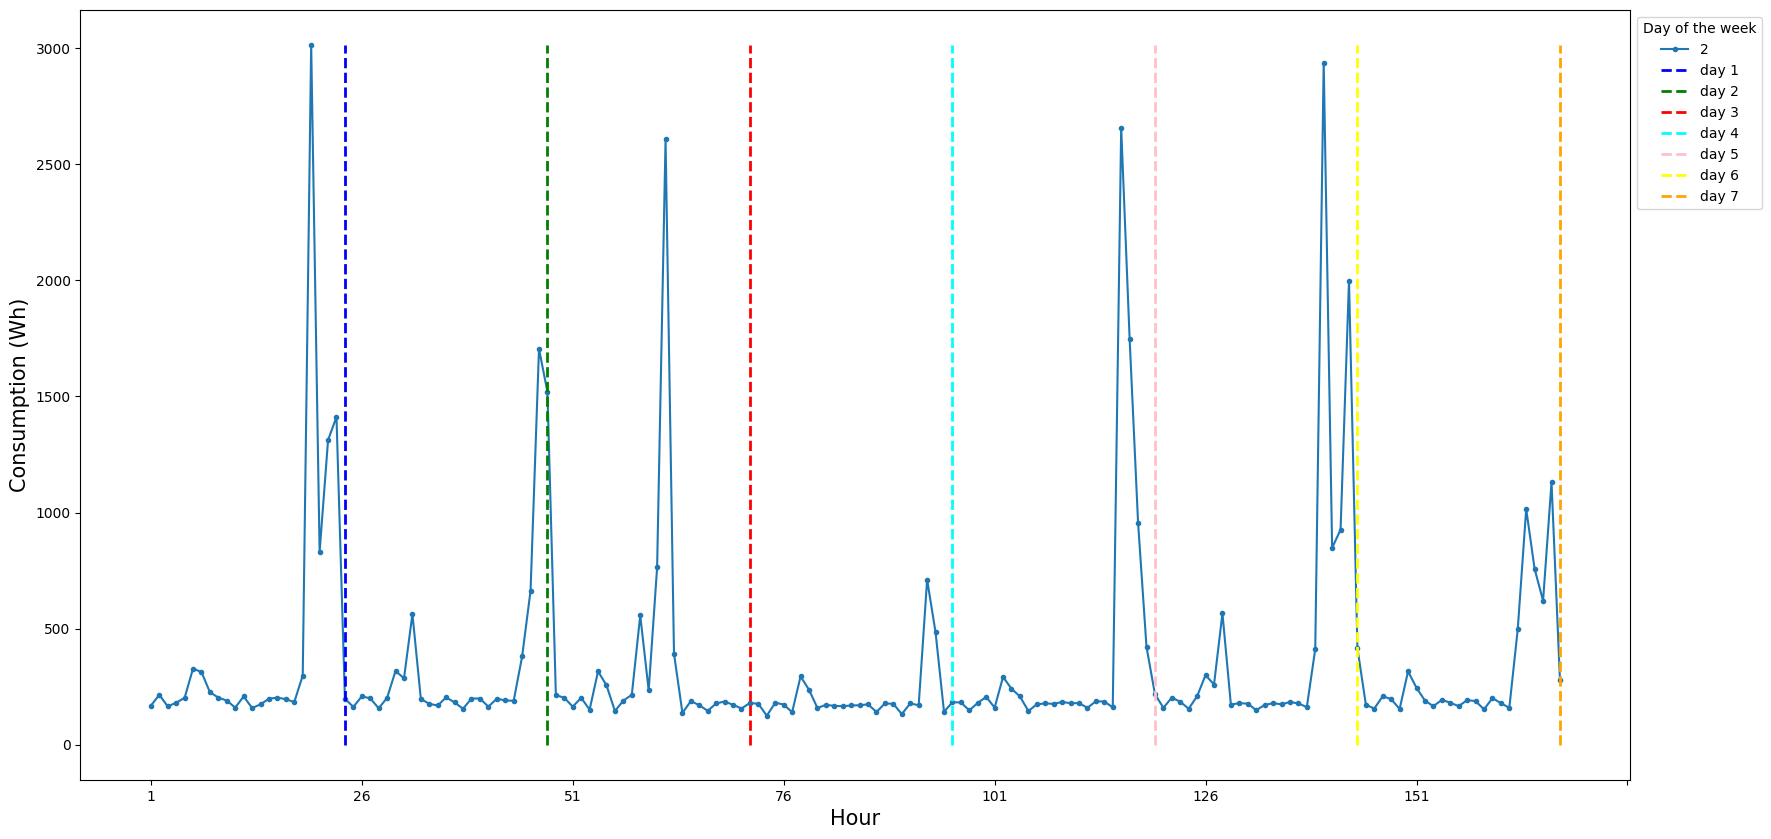

In [6]:
rowTS = (data_with_no_next_day_row.iloc[2])
aux.plot_time_series_with_week_separator(rowTS)

### Centroids for next day curves

Load 21 centroid model from Ireland

In [7]:
centroids = [ [ 666.40479893,  484.33481247,  403.49585082,  370.5242449 ,
         363.99568771,  391.12255842,  496.10640185,  659.05330929,
         732.29261459,  661.01002998,  626.41878595,  557.36233516,
         555.74481743,  628.43159322,  623.64899298,  647.05002927,
         688.73262013,  989.96810246, 1397.61470245, 1526.12345439,
        1467.50739569, 1424.30494595, 1277.73625541, 1007.61093758],
 [7988.88639466, 7268.74730775, 6804.77445776, 6640.17503413,
        6434.40785682, 6337.86303655, 6328.51327165, 6650.20203246,
        7212.94342484, 7726.6173214 , 8306.49582891, 8685.71105718,
        9029.67844684, 8995.13635674, 9000.76566055, 8950.58956469,
        9127.54664038, 9296.29713332, 9482.04307599, 9707.37919005,
        9684.54300015, 9512.9323525 , 8907.89276505, 8432.03579554],
 [5063.53569443, 4365.20704993, 3896.86967641, 3597.82525297,
        3459.25408651, 3456.88007339, 3567.78494385, 3849.55665518,
        4187.1664628 , 4334.57300122, 4484.80946292, 4604.65072834,
        4891.90164572, 4842.72334038, 4875.54475703, 5077.23446014,
        5581.56388302, 6209.94340042, 6724.0742244 , 7015.64422328,
        7026.27376849, 6932.77082175, 6616.3797954 , 5979.58968086],
 [ 664.64971722,  484.24338371,  403.54985479,  369.60886776,
         362.38005281,  393.0481233 ,  495.5519526 ,  690.89894635,
         841.49293436,  824.32571513,  840.90577216,  814.3801635 ,
         856.04135019,  902.06588095,  901.49747788, 1392.20289267,
        2653.60199451, 2977.45762989, 1610.71474955, 1378.71938267,
        1351.9737931 , 1336.13024388, 1202.78810991,  964.67879676],
 [8317.06892543, 8494.768477  , 8141.3019432 , 7593.31971433,
        6861.97176549, 6048.78790899, 5365.8445441 , 4482.35459226,
        2397.45523999, 2033.88739412, 2330.18285999, 2274.50357084,
        2217.54658695, 2044.82710513, 2013.83341638, 1976.31772131,
        1890.80468361, 1553.51934895, 1301.88290982, 1304.58379007,
        1332.65819631, 1404.31954825, 1763.12771965, 5746.45308088],
 [320.96178046, 255.8529408 , 229.07278026, 219.64003234,
        219.84097373, 230.34301883, 278.94034518, 365.18098082,
        400.59031706, 395.79920081, 372.54551802, 340.40825456,
        343.47485796, 352.78843204, 339.48136236, 350.84684382,
        383.45530162, 445.23904749, 459.05602476, 460.7941184 ,
        481.0623598 , 508.57178647, 488.21405724, 411.43217114],
 [ 744.03409614,  531.72816415,  450.16188436,  419.39059399,
         413.72691544,  434.3549074 ,  511.50830058,  770.96687654,
        2036.33027511, 4275.53008057, 2376.44072609, 1269.39402463,
        1136.45864168, 1099.6225371 , 1008.03069178, 1040.88979876,
        1179.39464241, 1439.46789521, 1541.92177868, 1564.42676691,
        1509.7273492 , 1470.47353409, 1314.84056047, 1037.55479173],
 [1601.16603784, 1170.65591189,  959.14439882,  878.8354325 ,
         843.33421184,  861.24551961, 1003.8459191 , 1423.54288964,
        2003.28488598, 2671.09454586, 3392.50585363, 3846.09160517,
        4295.97386673, 4593.98673917, 4619.61335516, 4631.94401598,
        4846.79961716, 5423.64528658, 5400.69708151, 4917.79620485,
        4308.65682739, 3766.67399989, 3124.9490096 , 2392.10758475],
 [3143.24018488, 2796.65769111, 2539.80058164, 2408.06945887,
        2377.95899979, 2403.00059722, 2524.84233486, 2824.19295285,
        2941.967984  , 2819.09906003, 2755.33350644, 2713.53733901,
        2693.8324678 , 2662.73995118, 2571.32922206, 2558.56930307,
        2656.32319796, 2854.96917844, 2976.30460636, 2999.86770357,
        3070.49085999, 3190.84841088, 3166.72546219, 3052.21214167],
 [ 924.00874251,  661.89334664,  548.39566201,  500.16010645,
         487.6160346 ,  507.34621424,  590.92546906,  818.70312708,
        1197.05776447, 1920.45172322, 4071.36357951, 4294.43602129,
        2469.61630073, 1647.86794411, 1424.84790419, 1408.84958084,
        1557.61201597, 1876.66726547, 1996.53409182, 2021.52737192,
        1928.34179641, 1826.09276114, 1607.99800399, 1261.05015303],
 [ 812.21019229,  574.68051668,  472.65269536,  433.00153241,
         427.64155564,  469.31139442,  633.07503918,  959.77076803,
        1098.21715461,  991.33350593,  982.19459528,  955.48468988,
         992.90856611, 1049.9502701 ,  969.16469576, 1005.36742891,
        1312.31778997, 2916.27394481, 4615.82014107, 3177.27366491,
        2249.42958604, 1897.53034035, 1592.4525932 , 1210.68650638],
 [ 642.57734751,  483.99367229,  403.49586352,  370.68959448,
         359.51990161,  370.07461016,  416.89810214,  523.60774039,
         728.8428407 ,  929.33392458, 1341.47870377, 1737.51633606,
        2046.35477174, 1563.61767427, 1046.05980638,  909.43473924,
         878.26403538,  957.53414122,  980.66428813,  948.69999323,
         956.18663598,  993.69464491,  951.83177397,  803.69112901],
 [ 878.4607494 ,  650.14644639,  533.69427373,  472.9124521 ,
         452.51305039,  463.77182597,  528.63582713,  700.44790688,
         930.56599306, 1070.47802943, 1222.95578772, 1297.33524329,
        1498.10612031, 2541.81275757, 3764.96807895, 3080.80275287,
        1989.60919312, 1668.09438038, 1638.56510737, 1642.48099378,
        1590.33541501, 1571.93889632, 1436.67476141, 1183.35150206],
 [1214.39438737, 1128.04979955, 1082.22638436, 1067.5663994 ,
        1058.08312453, 1050.55712854, 1090.87214984, 1445.62189927,
        3157.46172638, 7300.26265347, 8970.56746429, 9258.00745427,
        9114.90967176, 8316.58926334, 8724.38893761, 8678.63148334,
        8195.13248559, 6048.81589827, 2487.61644951, 1572.3070659 ,
        1318.12722375, 1259.56840391, 1214.6663117 , 1195.21485843],
 [3727.43318769, 3534.45903878, 3398.14127071, 3392.89249954,
        3368.24003277, 3374.38494447, 3544.37156381, 4360.42799927,
        6742.08747497, 9087.88376115, 9860.98124886, 9872.27571455,
        9851.59894411, 9491.13890406, 9352.42508647, 9260.12980157,
        9077.31139632, 7964.41307118, 6086.85882032, 5149.9208083 ,
        4354.26697615, 3901.54951757, 3563.21017659, 3571.9576734 ],
 [ 913.61542846,  781.63053205,  724.87335784,  706.45008692,
         704.80832692,  716.9262489 ,  825.49348836, 1145.99270468,
        2275.2919837 , 4475.50676812, 5440.60058135, 5554.70519506,
        5347.03126158, 4596.07266821, 4666.11293494, 4441.23652788,
        4042.72155253, 2942.87446924, 1637.88943034, 1323.41953777,
        1210.021373  , 1164.52400901, 1074.35912342,  965.97936793],
 [1104.78540487,  744.46498413,  585.5849443 ,  523.93598681,
         506.04348665,  541.99653327,  676.98950022,  969.2010145 ,
        1072.42832514,  945.66657746,  950.52198917,  937.85971868,
         967.88452107, 1014.9711396 ,  960.02245597, 1022.0998444 ,
        1160.32115516, 1427.85995519, 1800.21212423, 2745.17020601,
        3488.90814713, 3503.88833634, 2835.28454596, 1999.12927118],
 [1046.19702105,  743.46590955,  592.95869175,  524.10774715,
         499.38476497,  514.20733799,  593.71533901,  795.06843747,
        1088.80015664, 1319.82150622, 1615.09671452, 2615.47429544,
        4912.85032342, 3966.45790177, 2197.99292399, 1708.58566162,
        1698.25493903, 2016.31886622, 2229.6629306 , 2262.28522815,
        2153.13864394, 2075.5511458 , 1831.67612386, 1454.3954195 ],
 [1076.95739708,  767.7100562 ,  624.48005518,  558.85659564,
         539.21520344,  573.39004982,  735.66330358, 1175.04610281,
        1454.24856071, 1441.21697048, 1483.09184081, 1487.34782311,
        1584.88762726, 1790.97665219, 2100.87661457, 3135.88287333,
        4713.39260349, 4781.55077123, 3304.97372231, 2832.91886407,
        2614.59946191, 2434.11538242, 2092.13811462, 1608.12465087],
 [ 899.11416455,  684.02896997,  603.9178668 ,  582.95995188,
         597.02198954,  686.6068089 , 1234.00469333, 3534.1331761 ,
        2925.28366032, 1326.86539447, 1014.67541007,  952.45652718,
        1004.1651598 , 1033.69487427,  984.78516718, 1098.29171283,
        1332.94560983, 1725.28576874, 1808.8681104 , 1860.87802118,
        1773.77294548, 1722.19795352, 1549.18947218, 1225.38493609],
 [1433.63696948,  960.17417448,  757.08174241,  685.69120275,
         667.90362613,  713.51926642,  934.18354462, 1577.26653973,
        1825.25386247, 1631.31427569, 1592.29403217, 1551.69000017,
        1578.45990546, 1631.1542483 , 1610.63678576, 1772.0194418 ,
        2343.52502881, 3659.63499858, 4914.64129545, 5772.12142774,
        5439.95091113, 4704.81967898, 3740.83264018, 2635.09949725] ]

Convert list with centroids to time series data frame

In [8]:
dfCentroids = pd.DataFrame(centroids, columns = [*range(0, 24, 1)] ) 
dfCentroids = dfCentroids.round(0)
dfCentroids = dfCentroids.astype(int)
dfCentroids

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,666,484,403,371,364,391,496,659,732,661,...,624,647,689,990,1398,1526,1468,1424,1278,1008
1,7989,7269,6805,6640,6434,6338,6329,6650,7213,7727,...,9001,8951,9128,9296,9482,9707,9685,9513,8908,8432
2,5064,4365,3897,3598,3459,3457,3568,3850,4187,4335,...,4876,5077,5582,6210,6724,7016,7026,6933,6616,5980
3,665,484,404,370,362,393,496,691,841,824,...,901,1392,2654,2977,1611,1379,1352,1336,1203,965
4,8317,8495,8141,7593,6862,6049,5366,4482,2397,2034,...,2014,1976,1891,1554,1302,1305,1333,1404,1763,5746
5,321,256,229,220,220,230,279,365,401,396,...,339,351,383,445,459,461,481,509,488,411
6,744,532,450,419,414,434,512,771,2036,4276,...,1008,1041,1179,1439,1542,1564,1510,1470,1315,1038
7,1601,1171,959,879,843,861,1004,1424,2003,2671,...,4620,4632,4847,5424,5401,4918,4309,3767,3125,2392
8,3143,2797,2540,2408,2378,2403,2525,2824,2942,2819,...,2571,2559,2656,2855,2976,3000,3070,3191,3167,3052
9,924,662,548,500,488,507,591,819,1197,1920,...,1425,1409,1558,1877,1997,2022,1928,1826,1608,1261


**Plot centroids**

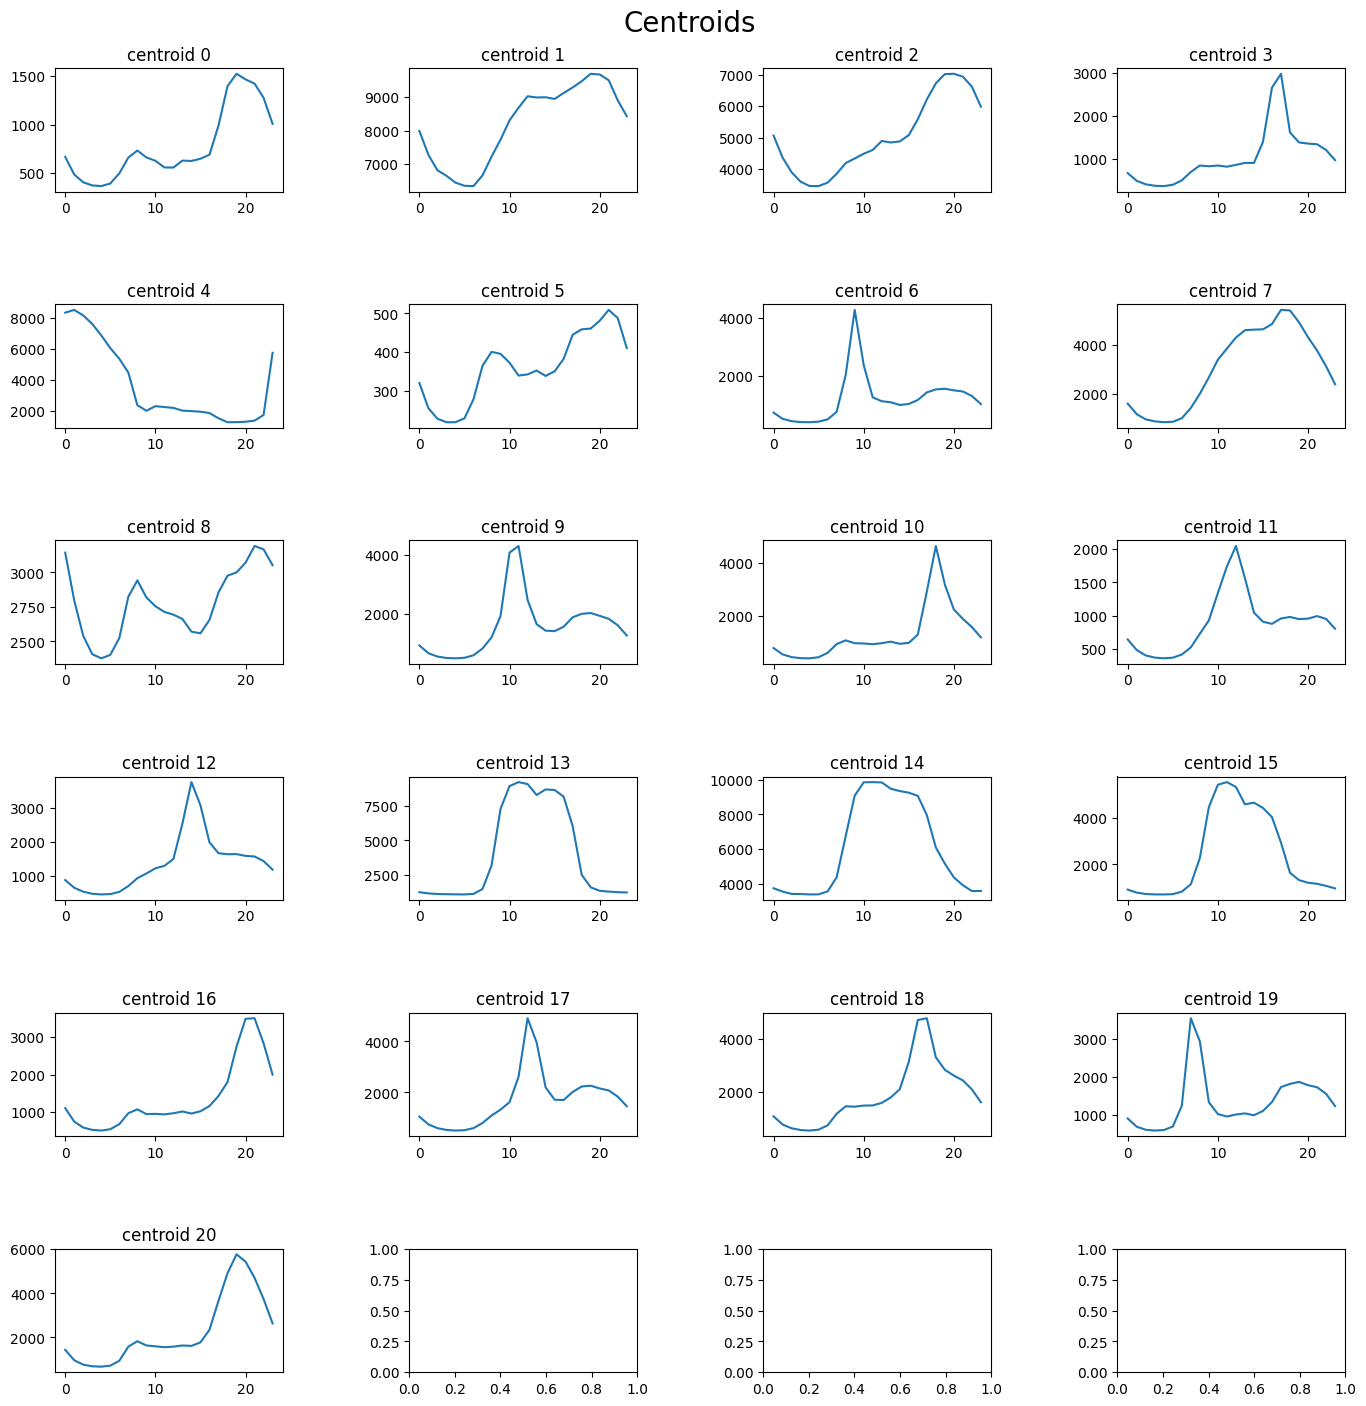

In [9]:
M =6
N= 4
fig, axs = plt.subplots(M, N,figsize=(15,15))
fig.tight_layout(pad=6.0)
fig.suptitle('Centroids', fontsize=20)
centroids_id = 0
for i in range(M):
    for j in range(N):
            if centroids_id<len(centroids):
                axs[i,j].plot(dfCentroids.iloc[centroids_id])
                axs[i, j].set_title("centroid " + str(centroids_id))
                centroids_id+=1

## Imaging Time Series

### Modelling Neural Network Input Week Time series as 2D images

Each weekly consumption time series is converted to a 2D image format that can be manipulated by the deep learning algorithms.

**Example of first week consumption of time series dataframe**

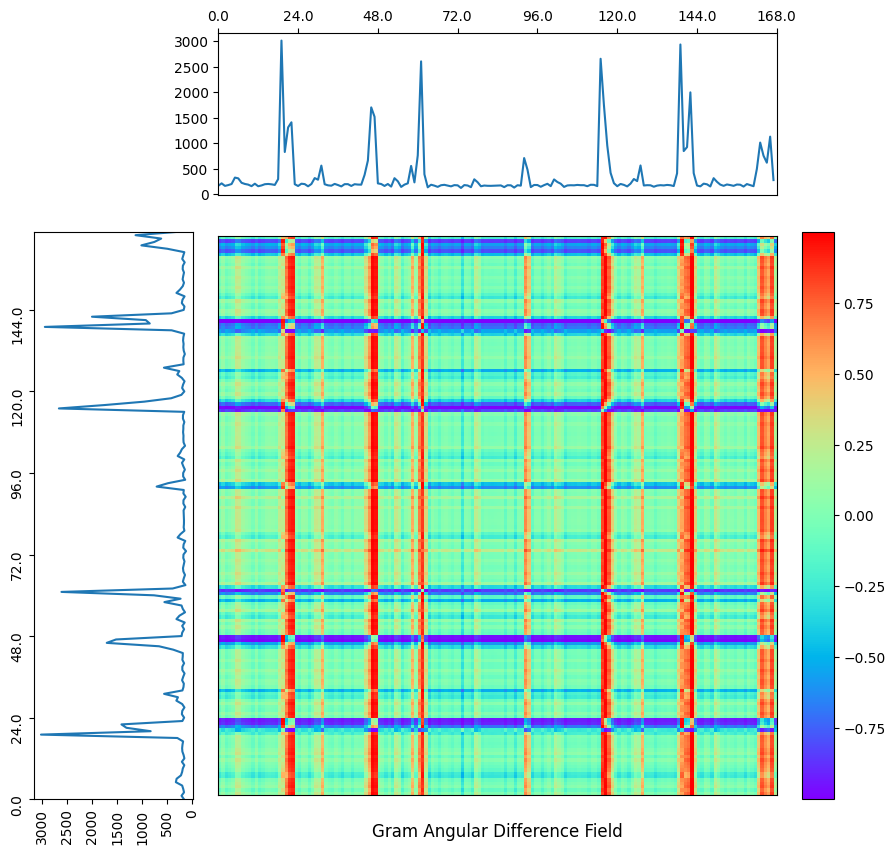

In [10]:
ts_week = data_with_no_next_day_row.iloc[2]
gaf_ts_diff = image_processing.transform_image_with_gram_angular_field(ts_week, method='difference')
image_processing.plot_gram_angular_field(ts_week,gaf_ts_diff)

### Example for polar coordinates time series plot

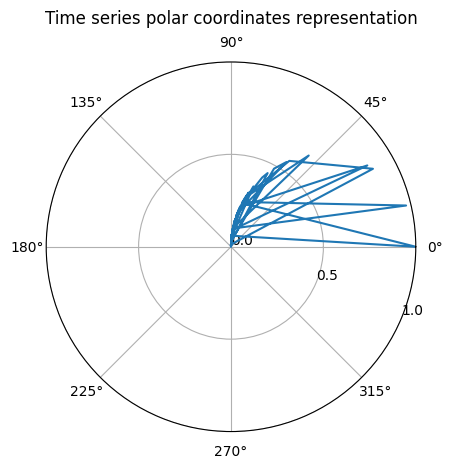

In [11]:
# get time series normalized between 0 and 1
normalize_ts_ = image_processing.normalize_ts(data_with_no_next_day_row.iloc[2])
# get polar coords from normalized ts
(phi,r) = image_processing.polar_rep(normalize_ts_)
#plot image in polar coordinate system
image_processing.plot_polar_coords(phi,r)

### Example of cluster in Gram Domain

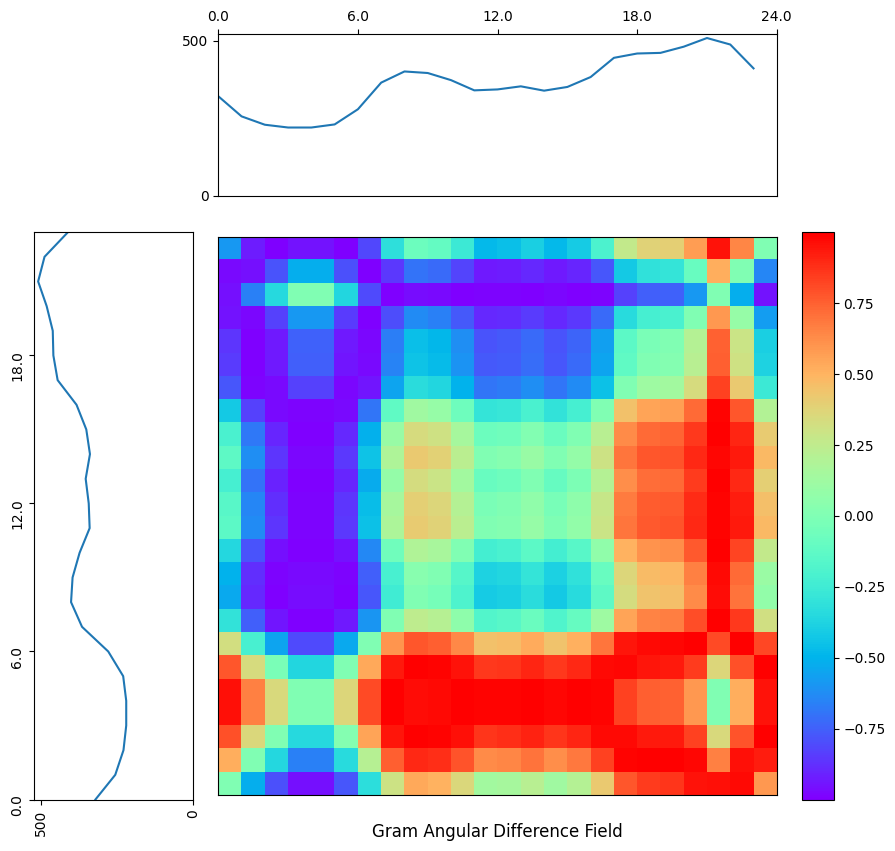

In [12]:
ts_cluster = dfCentroids.iloc[5]
gaf_ts_diff = image_processing.transform_image_with_gram_angular_field(ts_cluster, method='difference')
image_processing.plot_gram_angular_field (ts_cluster,gaf_ts_diff,type_ts='cluster')

### Generate input neural network images (week consumptions on Gram domain)

In [13]:
# Calculate Gram Angular Difference Field
input_nn = data_with_no_next_day_row.apply( 
    image_processing.transform_image_with_gram_angular_field,
    axis=1)


### Generate output neural network (next day consumption cluster on Gram Domain)

**Esto solo lo usaremos si nos da por probar a entrenar modelos con la transformada de Gramm de los clusteres de consumo del día siguiente como etiqueta (salida de la red), suponiendo que fuera posible. Nuestra primera alternativa solo usará las entradas (consumos semanales) en el dominio de Gramm. La salida para entrenar los modelos y lo que los modelos serán capaces de predecir, serán las propias etiquetas del cluster de consumo del día siguiente.**

In [14]:
# Calculate Gramian Angular Difference Field
output_nn = dfCentroids.apply( 
    image_processing.transform_image_with_gram_angular_field,
    axis=1)

### Save input (week) and output (daily) Gram domain matrices as csv

In [125]:
import os  

os.makedirs('../data/images/input', exist_ok=True)  
input_nn.to_csv('../data/images/input/input_images.csv') 

os.makedirs('../data/images/output', exist_ok=True)  
output_nn.to_csv('../data/images/output/output_images.csv') 

### Save input (week consumption on Gram matrix format) as PNG images 

Create a folder structure to store the weekly images in Gram domain that belong to each class
|next_day_cluster_0| ... |next_day_cluster_n|

In [24]:
next_day_clusters = [*range(0,len(dfCentroids))]
aux.create_folder_structure(next_day_clusters)

Saves as RGB images the GRAM matrices of weekly consumptions in the corresponding folder according to the cluster class of the next day of consumption. 

In [25]:
labels = data["next_day_cluster"]
image_processing.save_rgb_images(input_nn,labels)

## Train Deep Larning model

Create an instance of deep learning object with basic params setting for machine learning process

In [2]:
dl = deep_learning.DeepLearning(
    img_width = 128,
    img_height = 128,
    epochs = 100,
    batch_size=32,
    img_channels = 3
)

Split dataset in training and test

In [3]:
# Each week consumption RGB image in Gramm  domain
input_images_path = '../data/images/input'

# Split dataset into test and train
dl.split_train_and_test(dataset_url = input_images_path)

Found 529 files belonging to 21 classes.
Using 371 files for training.
Found 529 files belonging to 21 classes.
Using 158 files for validation.
class names:['next_day_cluster_0', 'next_day_cluster_1', 'next_day_cluster_10', 'next_day_cluster_11', 'next_day_cluster_12', 'next_day_cluster_13', 'next_day_cluster_14', 'next_day_cluster_15', 'next_day_cluster_16', 'next_day_cluster_17', 'next_day_cluster_18', 'next_day_cluster_19', 'next_day_cluster_2', 'next_day_cluster_20', 'next_day_cluster_3', 'next_day_cluster_4', 'next_day_cluster_5', 'next_day_cluster_6', 'next_day_cluster_7', 'next_day_cluster_8', 'next_day_cluster_9']


Plot first 9 images of training dataset

2024-02-29 16:59:58.843079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


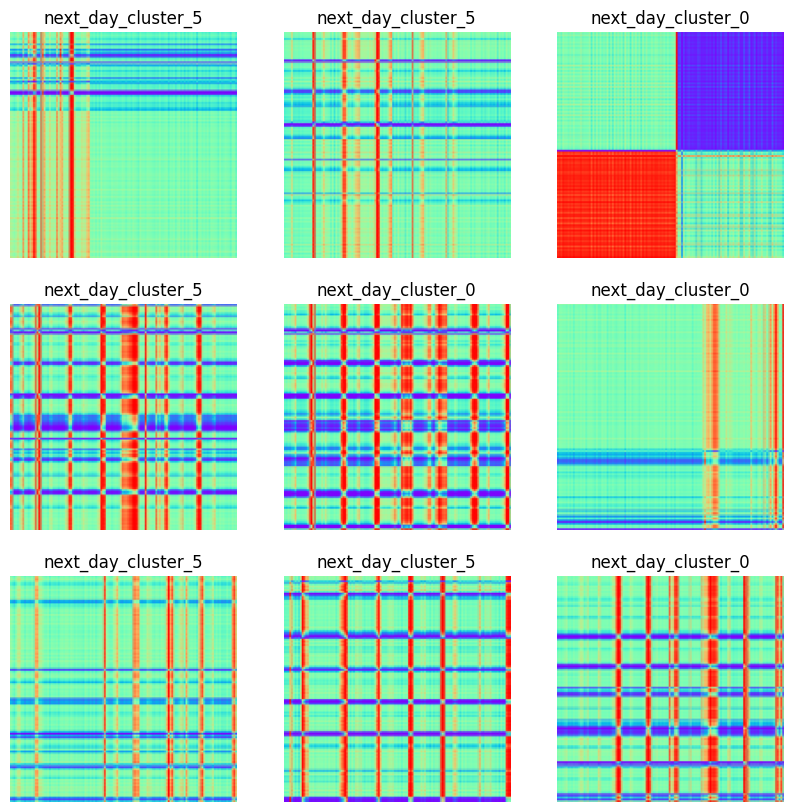

In [5]:
image_processing.visualize_train_dataset(dl.train_ds,dl.class_names)

Train model and show results

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.2695 - loss: 2.8315 - val_accuracy: 0.5000 - val_loss: 1.2937
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5023 - loss: 1.3344 - val_accuracy: 0.5000 - val_loss: 1.3370
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.4866 - loss: 1.3061 - val_accuracy: 0.4937 - val_loss: 1.2995
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5476 - loss: 1.2345 - val_accuracy: 0.5570 - val_loss: 1.2089
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5436 - loss: 1.1737 - val_accuracy: 0.5000 - val_loss: 1.2580
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5772 - loss: 1.0879 - val_accuracy: 0.4937 - val_loss: 1.2570
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5872 - loss: 1.0142 - val_accuracy: 0.5063 - val_loss: 1.2616
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6677 - loss: 0.9526 - val_accu

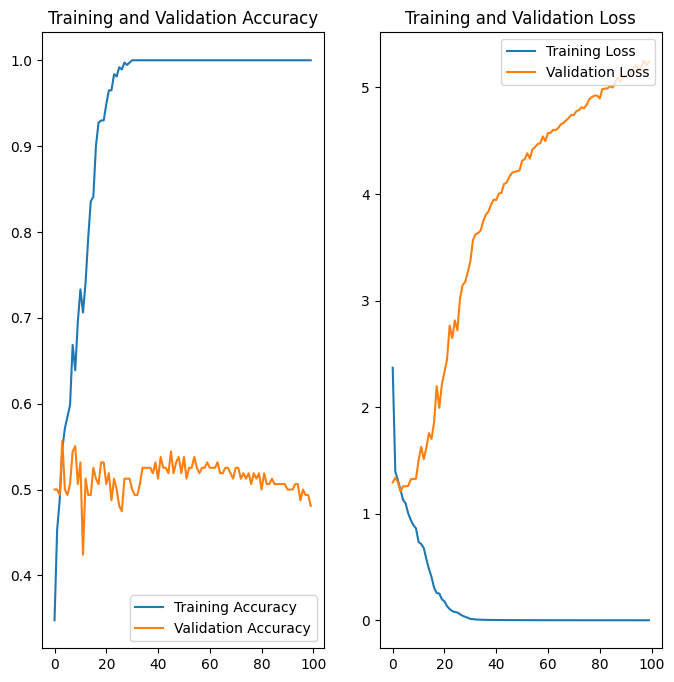

In [4]:
dl.train_model()
dl.show_results()

{(0, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0c6c7d0>,
 (0, 0, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb4830>,
 (0, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb4d70>,
 (0, 1, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb5100>,
 (0, 2, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb54f0>,
 (0, 2, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb5910>,
 (0, 3, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0c56f30>,
 (0, 3, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0c30080>,
 (0, 4, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb5a90>,
 (0, 4, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb5f10>,
 (0, 5, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb6330>,
 (0, 5, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb67b0>,
 (0, 6, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x2a0cb6b70>,
 (0, 6, 2): <mpl_toolkits.mplot3d.art3

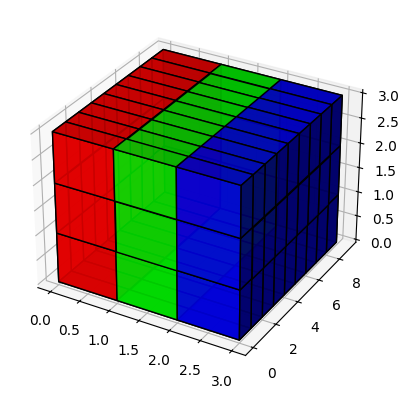

In [56]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
 
 
# Create axis
axes = [3, 9, 3]
 
# Create Data
data = np.ones(axes, dtype=np.bool_)
 
# Control Transparency
alpha = 0.9
 
# Control colour
colors = np.empty(axes + [4], dtype=np.float32)
 
colors[:] = [0, 1, 0, alpha]  # red

colors[0] = [1, 0, 0, alpha]  # red
colors[1] = [0, 1, 0, alpha]  # green
colors[2] = [0, 0, 1, alpha]  # blue

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Voxels is used to customizations of the
# sizes, positions and colors.
ax.voxels(data, facecolors=colors, edgecolors='k')

In [11]:
import numpy as np

def plot_rgb_channels(img):

    np_image = np.asarray(img)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)

    plt.imshow(np_image[:, :, 0], cmap='Reds', vmin=0, vmax=255)
    plt.title("Red Channel")
    plt.subplot(132)

    plt.imshow(np_image[:, :, 1], cmap='Greens', vmin=0, vmax=255)
    plt.title("Green Channel")
    plt.subplot(133)

    plt.imshow(np_image[:, :, 2], cmap='Blues', vmin=0, vmax=255)
    plt.title("Blue Channel")

    plt.show()

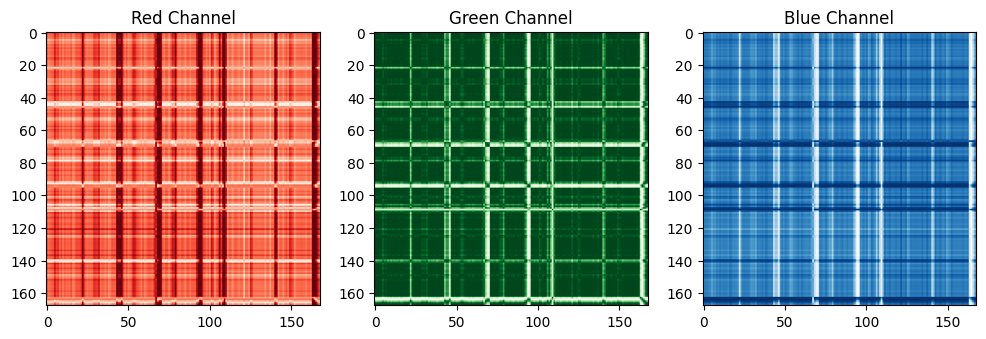

In [12]:
from PIL import Image
plot_rgb_channels ( Image.open("../data/images/input/next_day_cluster_0/0.png"))

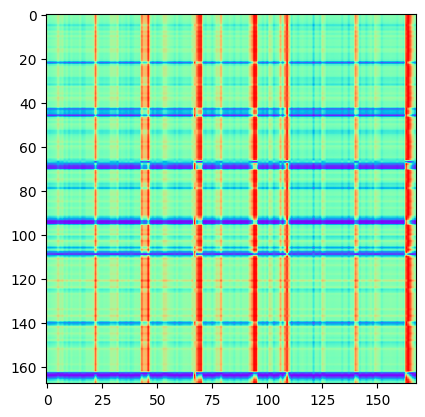

In [26]:
plt.imshow(input_nn[0],cmap='rainbow')